In [15]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

import seaborn as sns
import matplotlib.pyplot as mth
import statsmodels.formula.api as smf

In [16]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import random

In [21]:
data = pd.read_csv('haberman.csv', names=['age', 'operation_year', 'axil_nodes', 'survival_status'])
data.head()

,age,operation_year,axil_nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [22]:
cdf = thinkstats2.Cdf(data.age, label='cdf')

In [23]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [24]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

In [26]:
print(cdf[30])
print(sf[30])

0.00980392156862745
0.9901960784313726


About 1% of the people who has a cancer are younger than 30

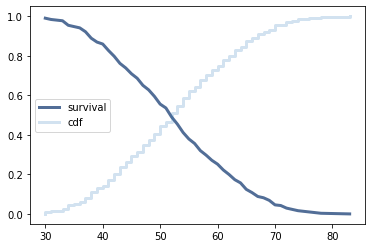

In [27]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

The plot above is the cdf and survival curve for age of the patients

In [117]:
hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.0036764705882353353


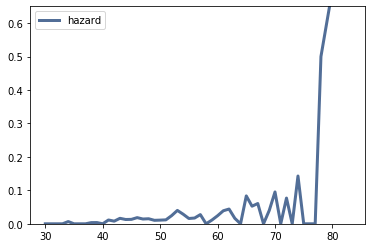

In [118]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.65], loc='upper left')

Here's the hazard curve.

The horizontal axis shows the time to event. 

And the vertical axis shows the cumulative hazard.



# Year of diagnosis


For this section I decided to show the complete as the ages of people who didn't survive the next 5 years after the diagnosis, whereas ongoing refered to people who survived the following 5 years of their lives

In [115]:

complete = data[data.survival_status==2].age
ongoing = data[data.survival_status==1].age


In [116]:

from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):

    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

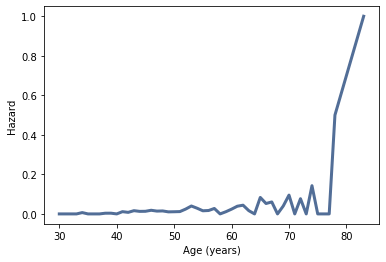

In [33]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

In here we've computed Kaplan-Meier estimation, which is known for estimation the hazard function, then converting the hazard function to a survival curve.

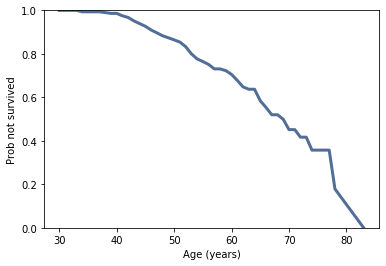

In [119]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob not survived',
                 ylim=[0, 1])

So the above survival function shows that the more people aging, the more is the probability of their not surviving the next 5 years after the cancer diagnosis

## Quantifying uncertainty

To see how much the results depend on random sampling, we'll use a resampling process again.

In [62]:
def EstimateMarriageSurvival(data):

    complete = data[data.survival_status==2].age.dropna()
    ongoing = data[data.survival_status==1].age.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [63]:
def ResampleSurvival(data, iters=101):
    _, sf = EstimateMarriageSurvival(data)
    thinkplot.Plot(sf)

    low, high = data.age.min(), data.age.max()
    ts = np.arange(low, high, 1)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(data)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

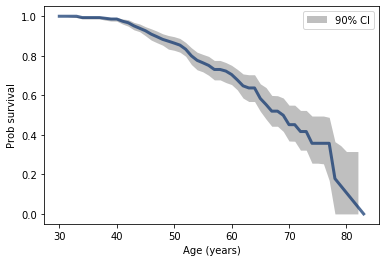

In [65]:
ResampleSurvival(data)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob survival',
                 loc='upper right')

The above plot shows the survival function 90% of confidence interval based on resampling.

In [89]:
data_first_five_years = data[data.operation_year < 64].dropna()
data_next_five_years = data[data.operation_year >= 64].dropna()

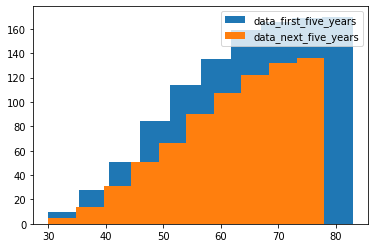

In [114]:
mth.hist(data_first_five_years.age, cumulative=True, label='data_first_five_years')
mth.hist(data_next_five_years.age, cumulative=True, label='data_next_five_years')
mth.legend(loc='upper right')
mth.show()

In [105]:
complete = data[data.survival_status==2].age
print('Number of people not survived 5 years after diagnosis', len(complete))
ongoing = data[data.survival_status==1].age
print('Number of people survived 5 years after diagnosis', len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of people not survived 5 years after diagnosis 81
Number of people survived 5 years after diagnosis 225


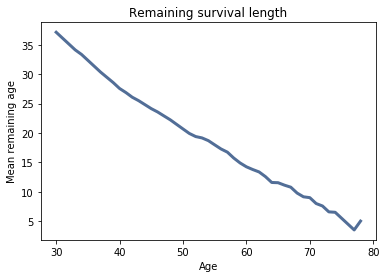

In [121]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining survival length',
                 xlabel='Age',
                 ylabel='Mean remaining age')

Here's the expected remaining age of people as a function of the number of years.  By the end of the X axis there is a sharp increse which can be due to outliers